# Setup & Preprocessing / Exploration

In [1]:
# ================================
# Mount Google Drive
# ================================
from google.colab import drive
drive.mount('/content/drive')

# Dataset path
DATA_PATH = "/content/drive/MyDrive/datasets/CICIDS2017/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ================================
# Import libraries
# ================================
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# PyTorch + Sklearn
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)

In [3]:
# ================================
# Load all CSV files
# ================================
csv_files = glob.glob(DATA_PATH + "*.csv")
print("Found files:", csv_files)

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
print("Full dataset shape:", full_df.shape)

Found files: ['/content/drive/MyDrive/datasets/CICIDS2017/Wednesday-workingHours.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Tuesday-WorkingHours.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Friday-WorkingHours-Morning.pcap_ISCX.csv', '/content/drive/MyDrive/datasets/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']
Full dataset shape: (2830743, 79)


    Destination Port   Flow Duration   Total Fwd Packets  \
0                 80           38308                   1   
1                389             479                  11   
2                 88            1095                  10   
3                389           15206                  17   
4                 88            1092                   9   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        1                            6   
1                        5                          172   
2                        6                         3150   
3                       12                         3452   
4                        6                         3150   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             6                       6   
1                           326                      79   
2                          3150                    1575   
3                          6660                 

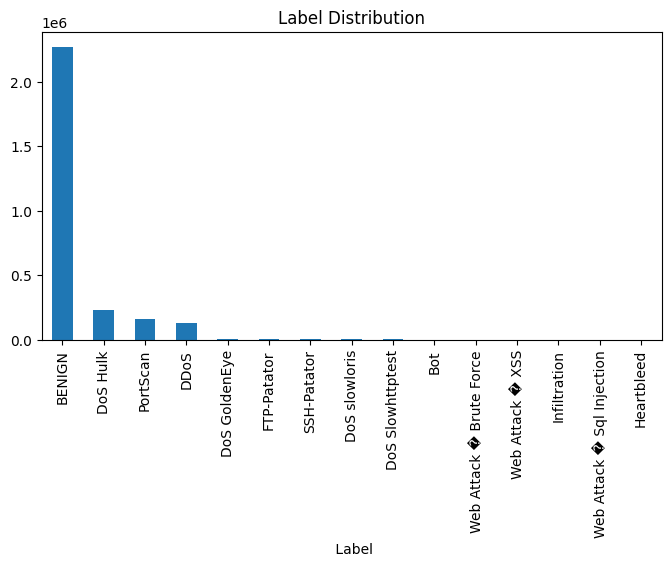

In [6]:
# ================================
# Quick dataset exploration
# ================================
print(full_df.head())
print(full_df.info())
print(full_df.describe())

# Label distribution
print(full_df[' Label'].value_counts())

plt.figure(figsize=(8,4))
full_df[' Label'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.show()

Columns with missing values:
 Flow Bytes/s    1358
dtype: int64


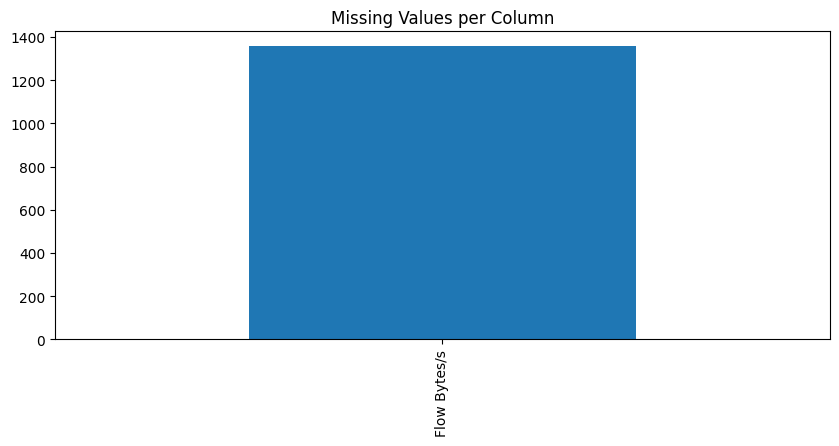

In [6]:
# ================================
# Missing values check
# ================================
missing = full_df.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)

plt.figure(figsize=(10,4))
missing.plot(kind='bar')
plt.title("Missing Values per Column")
plt.show()

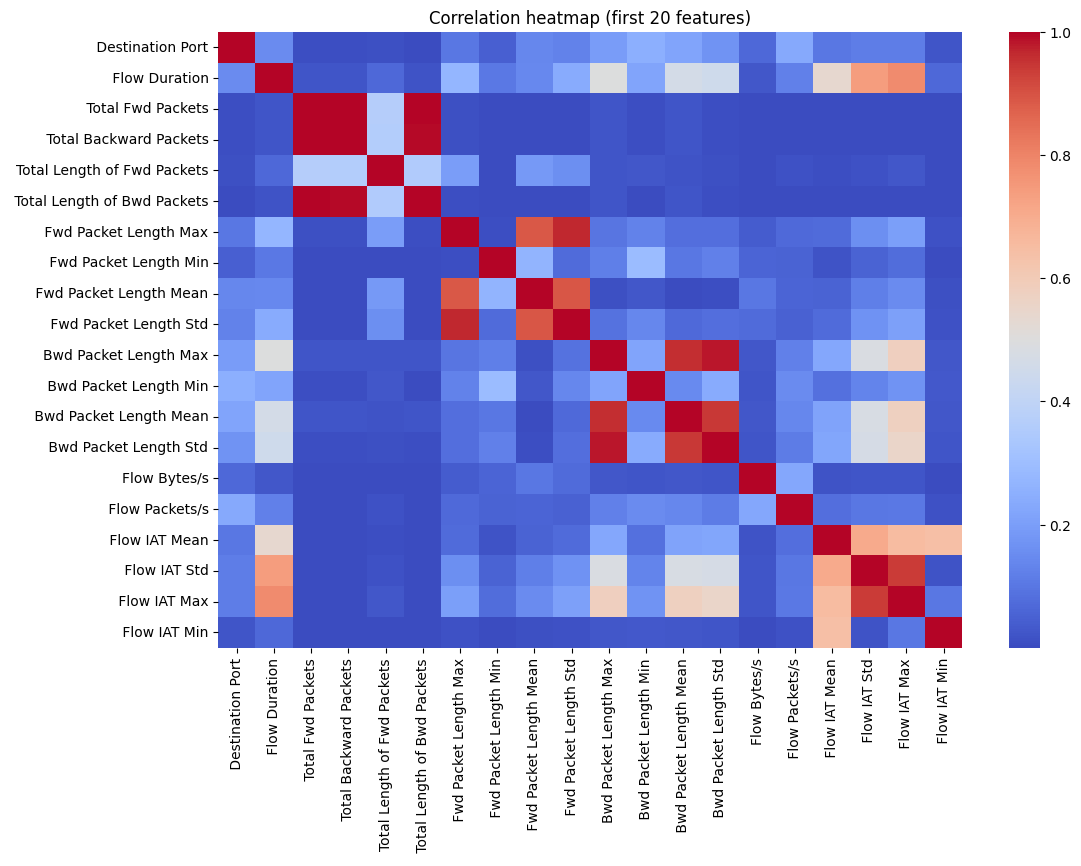

In [7]:
# ================================
# Correlation heatmap (optional)
# ================================
numeric_df = full_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr().abs().iloc[:20, :20], cmap="coolwarm")
plt.title("Correlation heatmap (first 20 features)")
plt.show()

In [4]:
# ================================
# Encode labels (BENIGN = 0, others = 1)
# ================================
def encode_labels(df):
    le = LabelEncoder()
    df[' Label'] = le.fit_transform(df[' Label'])
    df[' Label'] = df[' Label'].apply(lambda x: 0 if le.classes_[x] == 'BENIGN' else 1)
    return df

full_df = encode_labels(full_df)

# Keep only numeric
full_df = full_df.select_dtypes(include=[np.number])

print("Dataset after label encoding + numeric filter:", full_df.shape)

Dataset after label encoding + numeric filter: (2830743, 79)


In [5]:
# ================================
# Features & Labels + Cleaning
# ================================
X = full_df.drop(' Label', axis=1).values
y = full_df[' Label'].values

# Replace inf -> nan
X[np.isinf(X)] = np.nan

# Drop rows with NaN
mask = ~np.isnan(X).any(axis=1)
X, y = X[mask], y[mask]

print("Final dataset shape:", X.shape, "Labels shape:", y.shape)

Final dataset shape: (2827876, 78) Labels shape: (2827876,)


In [6]:
# ================================
# Standardize
# ================================
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (2262300, 78) Test: (565576, 78)


# Federated GRU Model

In [11]:
# ================================
# Federated client split
# ================================
NUM_CLIENTS = 5
BATCH_SIZE = 64
LR = 0.001
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

clients_data = []
size = len(X_train) // NUM_CLIENTS
start = 0
for i in range(NUM_CLIENTS):
    end = start + size if i < NUM_CLIENTS - 1 else len(X_train)
    clients_data.append((X_train[start:end], y_train[start:end]))
    start = end

In [12]:
# ================================
# Dataset class
# ================================
class IDS_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
# ================================
# GRU Model
# ================================
class GRU_IDS(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, output_dim=2):
        super(GRU_IDS, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, seq=1, input_dim)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [14]:
# ================================
# Training & Evaluation helpers
# ================================
def train_local_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for _ in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(DEVICE)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1).cpu().numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_scores.extend(probs[:,1].cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

def aggregate_models(global_model, local_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack(
            [local_models[i].state_dict()[key].float() for i in range(len(local_models))], 0
        ).mean(0)
    global_model.load_state_dict(global_dict)

In [15]:
# ================================
# Federated Training (GRU)
# ================================
input_dim = X_train.shape[1]
global_model = GRU_IDS(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()

for round in range(NUM_EPOCHS):
    local_models = []
    print(f"Round {round+1}/{NUM_EPOCHS}")
    for client_idx in range(NUM_CLIENTS):
        local_model = GRU_IDS(input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        optimizer = torch.optim.Adam(local_model.parameters(), lr=LR)

        train_x, train_y = clients_data[client_idx]
        train_dataset = IDS_Dataset(train_x, train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        train_local_model(local_model, train_loader, criterion, optimizer, epochs=1)
        local_models.append(local_model)

    aggregate_models(global_model, local_models)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5


In [16]:
# ================================
# Evaluate Global Model
# ================================
test_dataset = IDS_Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_scores = evaluate_model(global_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

Accuracy: 0.9826
Precision: 0.9498
Recall: 0.9623
F1-score: 0.9560
ROC AUC: 0.9982
PR AUC: 0.9928


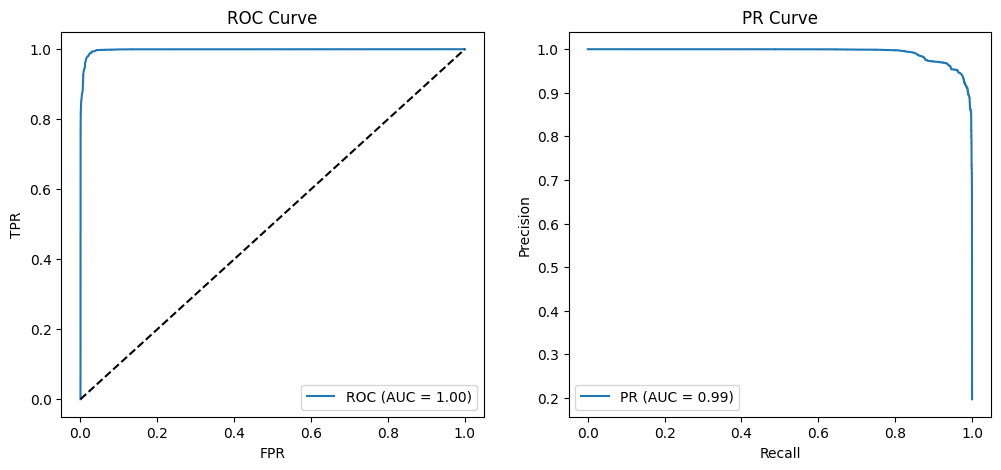

In [17]:
# ================================
# Plot ROC and PR
# ================================
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f"PR (AUC = {pr_auc:.2f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend()

plt.show()

# GRU for non-iid data

In [18]:
# ================================
# NON-IID Client Partition (Label-skewed)
# ================================
def noniid_partition(X, y, num_clients=NUM_CLIENTS, seed=42):
    np.random.seed(seed)
    idx_0 = np.where(y == 0)[0]   # BENIGN
    idx_1 = np.where(y == 1)[0]   # Attack

    np.random.shuffle(idx_0)
    np.random.shuffle(idx_1)

    size_0 = len(idx_0) // num_clients
    size_1 = len(idx_1) // num_clients

    clients_data = []
    for i in range(num_clients):
        if i % 2 == 0:  # even clients → mostly BENIGN
            main_idx = idx_0[size_0*i : size_0*(i+1)]
            other_idx_end = min(len(idx_1), size_1*(i//3 + 1))
            other_idx = idx_1[size_1*i//3 : other_idx_end]
        else:           # odd clients → mostly ATTACK
            main_idx = idx_1[size_1*i : size_1*(i+1)]
            other_idx_end = min(len(idx_0), size_0*(i//3 + 1))
            other_idx = idx_0[size_0*i//3 : other_idx_end]

        indices = np.concatenate((main_idx, other_idx))
        np.random.shuffle(indices)
        clients_data.append((X[indices], y[indices]))

    return clients_data

# Create non-IID clients
clients_data = noniid_partition(X_train, y_train, NUM_CLIENTS)

# Quick sanity check: print class distribution per client
for i, (Xc, yc) in enumerate(clients_data):
    unique, counts = np.unique(yc, return_counts=True)
    print(f"Client {i}: ", dict(zip(unique, counts)))

Client 0:  {np.int64(0): np.int64(363411), np.int64(1): np.int64(89049)}
Client 1:  {np.int64(0): np.int64(242274), np.int64(1): np.int64(89049)}
Client 2:  {np.int64(0): np.int64(363411), np.int64(1): np.int64(29683)}
Client 3:  {np.int64(0): np.int64(363411), np.int64(1): np.int64(89049)}
Client 4:  {np.int64(0): np.int64(363411), np.int64(1): np.int64(59366)}


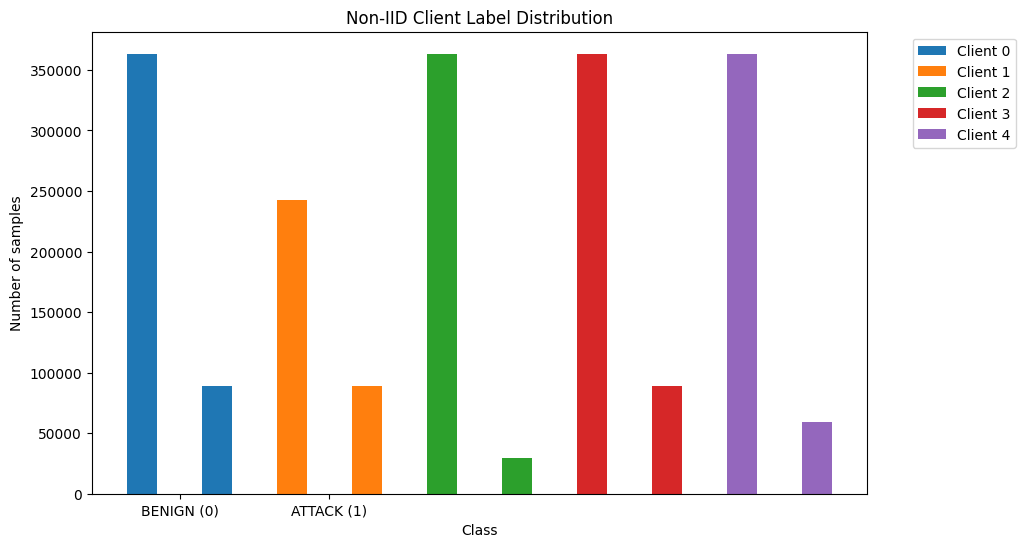

In [19]:
# ================================
# Plot class distribution per client
# ================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for i, (Xc, yc) in enumerate(clients_data):
    unique, counts = np.unique(yc, return_counts=True)
    plt.bar([i*2 + val for val in unique], counts, width=0.4, label=f"Client {i}" if i==0 else "")

plt.xticks([0.5, 2.5], ["BENIGN (0)", "ATTACK (1)"])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Non-IID Client Label Distribution")
plt.legend([f"Client {i}" for i in range(NUM_CLIENTS)], bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

In [20]:
# ================================
# Federated Training (GRU)
# ================================
input_dim = X_train.shape[1]
global_model = GRU_IDS(input_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()

for round in range(NUM_EPOCHS):
    local_models = []
    print(f"Round {round+1}/{NUM_EPOCHS}")
    for client_idx in range(NUM_CLIENTS):
        local_model = GRU_IDS(input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())
        optimizer = torch.optim.Adam(local_model.parameters(), lr=LR)

        train_x, train_y = clients_data[client_idx]
        train_dataset = IDS_Dataset(train_x, train_y)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        train_local_model(local_model, train_loader, criterion, optimizer, epochs=1)
        local_models.append(local_model)

    aggregate_models(global_model, local_models)

Round 1/5
Round 2/5
Round 3/5
Round 4/5
Round 5/5


In [21]:
# ================================
# Evaluate Global Model
# ================================
test_dataset = IDS_Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_scores = evaluate_model(global_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

Accuracy: 0.9782
Precision: 0.9652
Recall: 0.9223
F1-score: 0.9433
ROC AUC: 0.9981
PR AUC: 0.9924


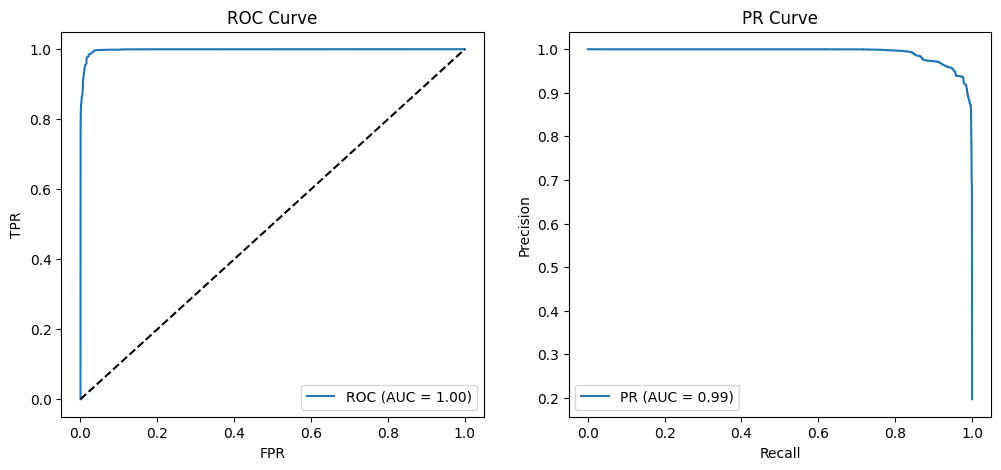

In [22]:
# ================================
# Plot ROC and PR
# ================================
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, label=f"PR (AUC = {pr_auc:.2f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend()

plt.show()

# PyTorch Dataset + DataLoader

In [15]:
# ================================
# PyTorch Dataset
# ================================
import torch
from torch.utils.data import Dataset, DataLoader

class CICDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Federated run config

In [7]:
# ================================
# Config for Federated run
# ================================
NUM_CLIENTS = 5
NUM_EPOCHS = 5           # federated rounds
LOCAL_EPOCHS = 1         # local epochs per round
BATCH_SIZE = 64
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FED_NONIID = True  # set to False for IID client split

In [8]:
# ================================
# Client partitioning (IID / Non-IID)
# ================================
import numpy as np

def iid_partition(X, y, num_clients=NUM_CLIENTS, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(X))
    rng.shuffle(idx)
    splits = np.array_split(idx, num_clients)
    return [(X[s], y[s]) for s in splits]

def noniid_partition(X, y, num_clients=NUM_CLIENTS, seed=42):
    np.random.seed(seed)
    idx_0 = np.where(y == 0)[0]   # BENIGN
    idx_1 = np.where(y == 1)[0]   # ATTACK
    np.random.shuffle(idx_0); np.random.shuffle(idx_1)

    size_0 = len(idx_0) // num_clients
    size_1 = len(idx_1) // num_clients

    clients_data = []
    for i in range(num_clients):
        if i % 2 == 0:  # even clients → mostly BENIGN
            main_idx = idx_0[size_0*i : size_0*(i+1)]
            other_idx_end = min(len(idx_1), size_1*(i//3 + 1))
            other_idx = idx_1[size_1*i//3 : other_idx_end]
        else:           # odd clients → mostly ATTACK
            main_idx = idx_1[size_1*i : size_1*(i+1)]
            other_idx_end = min(len(idx_0), size_0*(i//3 + 1))
            other_idx = idx_0[size_0*i//3 : other_idx_end]

        indices = np.concatenate((main_idx, other_idx))
        np.random.shuffle(indices)
        clients_data.append((X[indices], y[indices]))
    return clients_data

clients_data = noniid_partition(X_train, y_train, NUM_CLIENTS) if FED_NONIID else iid_partition(X_train, y_train, NUM_CLIENTS)

# Optional: quick distribution print
for i, (Xc, yc) in enumerate(clients_data):
    u, c = np.unique(yc, return_counts=True)
    print(f"Client {i} label counts:", dict(zip(u, c)))

Client 0 label counts: {np.int64(0): np.int64(363411), np.int64(1): np.int64(89049)}
Client 1 label counts: {np.int64(0): np.int64(242274), np.int64(1): np.int64(89049)}
Client 2 label counts: {np.int64(0): np.int64(363411), np.int64(1): np.int64(29683)}
Client 3 label counts: {np.int64(0): np.int64(363411), np.int64(1): np.int64(89049)}
Client 4 label counts: {np.int64(0): np.int64(363411), np.int64(1): np.int64(59366)}


# Federated CNN-GRU Model
  - CNN extracts local patterns over "time"
  - GRU models temporal dependencies
  - Safe padding to make features divisible into (seq_len, features_per_step)

In [21]:
class FedCNNGRU(nn.Module):
    def __init__(self, input_dim, seq_len=10, cnn_channels=64, gru_hidden=64, gru_layers=1, num_classes=2):
        super().__init__()
        self.seq_len = seq_len
        self.features_per_step = math.ceil(input_dim / seq_len)
        self.padded_dim = self.seq_len * self.features_per_step

        # 1D CNN over the temporal axis.
        # We reshape x to (batch, features_per_step, seq_len) so in_channels = features_per_step
        self.conv1 = nn.Conv1d(in_channels=self.features_per_step, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # halves the seq_len

        # GRU reads the time-reduced sequence, feature size = cnn_channels
        self.gru = nn.GRU(input_size=cnn_channels, hidden_size=gru_hidden, num_layers=gru_layers, batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(gru_hidden, num_classes)

    def forward(self, x):
        # x: (batch, input_dim)
        if x.size(1) < self.padded_dim:
            pad = x.new_zeros(x.size(0), self.padded_dim - x.size(1))
            x = torch.cat([x, pad], dim=1)
        elif x.size(1) > self.padded_dim:
            x = x[:, :self.padded_dim]

        # (batch, seq_len, features_per_step)
        x = x.view(x.size(0), self.seq_len, self.features_per_step)
        # to (batch, features_per_step, seq_len) for Conv1d
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)  # (batch, cnn_channels, seq_len//2)

        # to (batch, seq_len_reduced, cnn_channels) for GRU
        x = x.transpose(1, 2)

        out, _ = self.gru(x)          # (batch, seq_len_reduced, gru_hidden)
        out = out[:, -1, :]           # last time step
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

input_dim = X_train.shape[1]
global_model = FedCNNGRU(input_dim=input_dim).to(DEVICE)
print(global_model)

FedCNNGRU(
  (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (act): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(64, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [22]:
# ================================
# Local Train / Evaluate / FedAvg
# ================================
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score

criterion = nn.CrossEntropyLoss()

def train_local_model(model, loader, epochs=1, lr=LR, device=DEVICE):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

@torch.no_grad()
def evaluate_model(model, loader, device=DEVICE):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)
        y_scores.extend(probs[:,1].cpu().numpy())
    y_true = np.array(y_true); y_pred = np.array(y_pred); y_scores = np.array(y_scores)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc = roc_auc_score(y_true, y_scores)
    pr  = average_precision_score(y_true, y_scores)
    return acc, prec, rec, f1, roc, pr

def fedavg_aggregate(global_model, local_models):
    gsd = global_model.state_dict()
    # average parameters
    with torch.no_grad():
        for k in gsd.keys():
            gsd[k] = torch.stack([lm.state_dict()[k].float() for lm in local_models], dim=0).mean(dim=0)
    global_model.load_state_dict(gsd)

In [23]:
# ================================
# Federated Training Loop (FedAvg)
# ================================
test_loader = DataLoader(CICDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

for rnd in range(NUM_EPOCHS):
    print(f"\n=== Federated Round {rnd+1}/{NUM_EPOCHS} ===")
    local_models = []

    for cid in range(NUM_CLIENTS):
        Xc, yc = clients_data[cid]
        train_loader = DataLoader(CICDataset(Xc, yc), batch_size=BATCH_SIZE, shuffle=True)

        local_model = FedCNNGRU(input_dim=input_dim).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())  # start from global
        train_local_model(local_model, train_loader, epochs=LOCAL_EPOCHS, lr=LR, device=DEVICE)
        local_models.append(local_model)

    # Aggregate
    fedavg_aggregate(global_model, local_models)

    # Evaluate global
    acc, prec, rec, f1, roc, pr = evaluate_model(global_model, test_loader, device=DEVICE)
    print(f"Global -> Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")


=== Federated Round 1/5 ===
Global -> Acc: 0.9681 | Prec: 0.8944 | Rec: 0.9504 | F1: 0.9215 | ROC-AUC: 0.9954 | PR-AUC: 0.9834

=== Federated Round 2/5 ===
Global -> Acc: 0.9768 | Prec: 0.9541 | Rec: 0.9264 | F1: 0.9401 | ROC-AUC: 0.9974 | PR-AUC: 0.9900

=== Federated Round 3/5 ===
Global -> Acc: 0.9781 | Prec: 0.9650 | Rec: 0.9221 | F1: 0.9430 | ROC-AUC: 0.9980 | PR-AUC: 0.9921

=== Federated Round 4/5 ===
Global -> Acc: 0.9826 | Prec: 0.9451 | Rec: 0.9680 | F1: 0.9564 | ROC-AUC: 0.9981 | PR-AUC: 0.9925

=== Federated Round 5/5 ===
Global -> Acc: 0.9818 | Prec: 0.9395 | Rec: 0.9701 | F1: 0.9546 | ROC-AUC: 0.9981 | PR-AUC: 0.9925


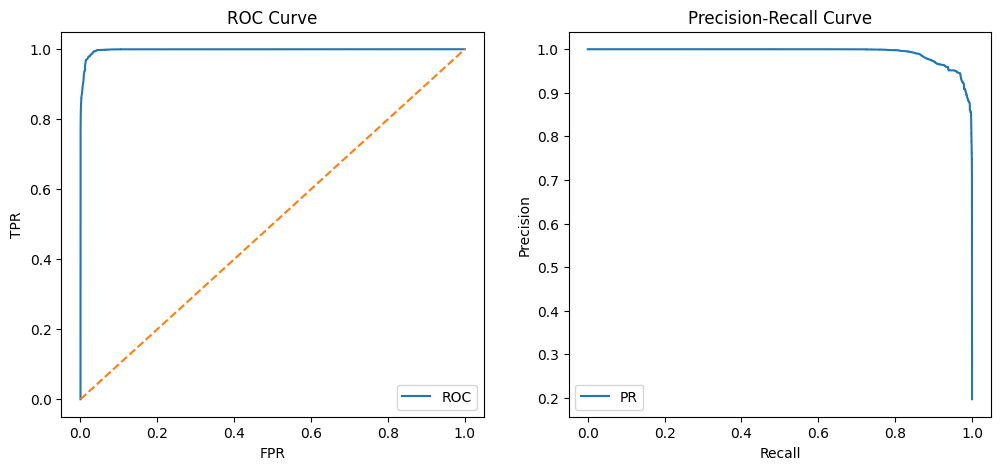

In [24]:
# ================================
# ROC & PR Curves
# ================================
from sklearn.metrics import roc_curve, precision_recall_curve

@torch.no_grad()
def collect_scores(model, loader, device=DEVICE):
    model.eval()
    y_true, y_scores = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        probs = torch.softmax(model(xb), dim=1)[:,1].cpu().numpy()
        y_true.extend(yb.numpy()); y_scores.extend(probs)
    return np.array(y_true), np.array(y_scores)

y_true, y_scores = collect_scores(global_model, test_loader, DEVICE)
fpr, tpr, _ = roc_curve(y_true, y_scores)
prec_c, rec_c, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_c, prec_c, label="PR")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()

# Datasets (unsupervised for AE training, labeled for eval)

In [9]:
# ================================
# Datasets for AE
# ================================
import torch
from torch.utils.data import Dataset, DataLoader

class UnlabeledDataset(Dataset):
    # for AE training (X only)
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        return x, x  # target is the same as input (reconstruction)

class LabeledDataset(Dataset):
    # for evaluation (scores vs labels)
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Autoencoder model (MLP)

In [10]:
# ================================
# MLP Autoencoder
# ================================
import torch.nn as nn

class MLP_Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, h1=512, h2=128, dropout=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h1), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, h2), nn.ReLU(),
            nn.Linear(h2, h1), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [10]:
# ================================
# Local training (AE) + FedAvg
# ================================
import numpy as np

MSE = nn.MSELoss(reduction='mean')

def train_local_ae(model, loader, epochs=1, lr=LR, device=DEVICE, denoise_prob=0.0):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        for xb, target in loader:
            xb = xb.to(device)
            target = target.to(device)

            # (optional) denoising autoencoder: random masking noise
            if denoise_prob > 0:
                noise_mask = torch.rand_like(xb) < denoise_prob
                xb = xb.masked_fill(noise_mask, 0.0)

            opt.zero_grad()
            recon = model(xb)
            loss = MSE(recon, target)
            loss.backward()
            opt.step()

@torch.no_grad()
def reconstruction_errors(model, loader, device=DEVICE):
    model.eval()
    errs, labels = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        recon = model(xb)
        err = ((recon - xb)**2).mean(dim=1).cpu().numpy()
        errs.extend(err)
        labels.extend(yb.numpy())
    return np.array(errs), np.array(labels)

def fedavg_aggregate(global_model, local_models):
    gsd = global_model.state_dict()
    with torch.no_grad():
        for k in gsd.keys():
            gsd[k] = torch.stack([lm.state_dict()[k].float() for lm in local_models], dim=0).mean(dim=0)
    global_model.load_state_dict(gsd)

In [12]:
# ================================
# Federated Autoencoder Training
#   - Train AE on BENIGN samples only (unsupervised)
#   - Non-IID/IID per your existing clients_data
# ================================
input_dim = X_train.shape[1]
global_model = MLP_Autoencoder(input_dim=input_dim, latent_dim=32, h1=512, h2=128, dropout=0.1).to(DEVICE)

# Precompute global benign pool (for clients with too few benign samples)
benign_mask_global = (y_train == 0)
X_train_benign = X_train[benign_mask_global]

for rnd in range(NUM_EPOCHS):
    print(f"\n=== Federated Round {rnd+1}/{NUM_EPOCHS} ===")
    local_models = []

    for cid in range(NUM_CLIENTS):
        Xc, yc = clients_data[cid]
        # Keep only BENIGN traffic for AE training
        mask_benign = (yc == 0)
        Xc_benign = Xc[mask_benign]

        # Fallback: if a client has too few benign samples, pull a small shard from global benign
        if len(Xc_benign) < max(32, BATCH_SIZE):
            take = max(0, max(32, BATCH_SIZE) - len(Xc_benign))
            if len(X_train_benign) > 0 and take > 0:
                idx = np.random.randint(0, len(X_train_benign), size=take)
                Xc_benign = np.concatenate([Xc_benign, X_train_benign[idx]], axis=0)

        train_loader = DataLoader(UnlabeledDataset(Xc_benign), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

        # local model starts from global
        local_model = MLP_Autoencoder(input_dim=input_dim, latent_dim=32, h1=512, h2=128, dropout=0.1).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())

        train_local_ae(local_model, train_loader, epochs=LOCAL_EPOCHS, lr=LR, device=DEVICE, denoise_prob=0.05)
        local_models.append(local_model)

    # FedAvg aggregation
    fedavg_aggregate(global_model, local_models)

    # Optional quick check: reconstruction error on a benign validation slice
    with torch.no_grad():
        val_idx = np.random.randint(0, len(X_train_benign), size=min(2000, len(X_train_benign)))
        val_loader = DataLoader(LabeledDataset(X_train_benign[val_idx], np.zeros(len(val_idx))), batch_size=BATCH_SIZE, shuffle=False)
        errs_benign, _ = reconstruction_errors(global_model, val_loader, DEVICE)
        print(f"Round {rnd+1}: benign recon err (mean±std) = {errs_benign.mean():.6f} ± {errs_benign.std():.6f}")



=== Federated Round 1/5 ===
Round 1: benign recon err (mean±std) = 0.444127 ± 1.543967

=== Federated Round 2/5 ===
Round 2: benign recon err (mean±std) = 0.132403 ± 0.530256

=== Federated Round 3/5 ===
Round 3: benign recon err (mean±std) = 0.244135 ± 4.333307

=== Federated Round 4/5 ===
Round 4: benign recon err (mean±std) = 0.070593 ± 0.281357

=== Federated Round 5/5 ===
Round 5: benign recon err (mean±std) = 0.084842 ± 2.169957


Chosen threshold (99th percentile of benign recon error): 0.625960
ACC: 0.8481 | PREC: 0.8683 | REC: 0.2692 | F1: 0.4110 | ROC-AUC: 0.7744 | PR-AUC: 0.5442


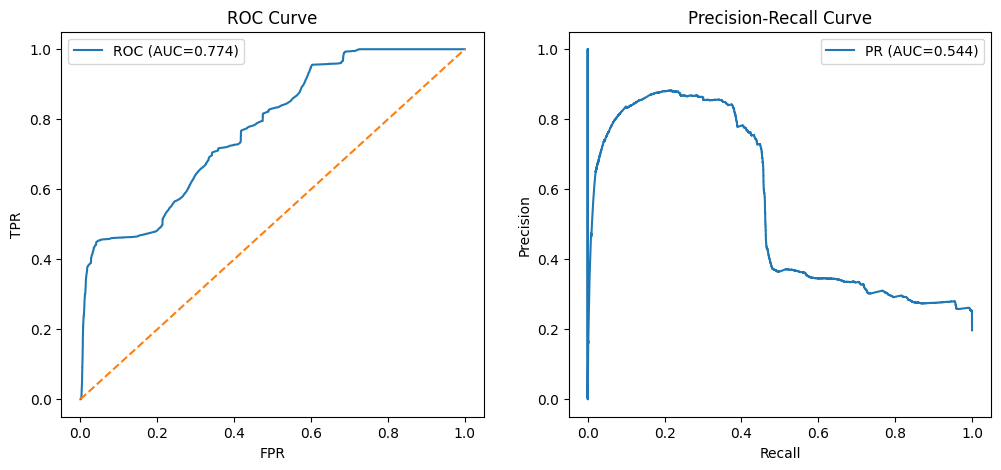

In [13]:
# ================================
# AE Evaluation as Anomaly Detector
#  - Threshold from benign training errors (e.g., 99th percentile)
# ================================
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import torch

# Build loaders
test_loader = DataLoader(LabeledDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# 1) Choose threshold from benign training distribution
with torch.no_grad():
    benign_loader = DataLoader(LabeledDataset(X_train_benign, np.zeros(len(X_train_benign))), batch_size=BATCH_SIZE, shuffle=False)
    benign_errs, _ = reconstruction_errors(global_model, benign_loader, DEVICE)

thresh = np.percentile(benign_errs, 99.0)   # tuneable: 95, 97.5, 99, etc.
print(f"Chosen threshold (99th percentile of benign recon error): {thresh:.6f}")

# 2) Score test set
test_errs, test_labels = reconstruction_errors(global_model, test_loader, DEVICE)

# Predictions: anomaly if recon error > threshold
y_pred = (test_errs > thresh).astype(int)

# Classification metrics
acc = accuracy_score(test_labels, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, y_pred, average='binary', zero_division=0)

# Ranking metrics (use errors as anomaly scores)
roc_auc = roc_auc_score(test_labels, test_errs)
pr_auc  = average_precision_score(test_labels, test_errs)

print(f"ACC: {acc:.4f} | PREC: {prec:.4f} | REC: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

# 3) Curves
fpr, tpr, _ = roc_curve(test_labels, test_errs)
prec_c, rec_c, _ = precision_recall_curve(test_labels, test_errs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_c, prec_c, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()

# Stacked Autoencoder model

In [11]:
# ================================
# Stacked Autoencoder (SAE)
#  - Deeper encoder/decoder than the simple AE
#  - Symmetric architecture with optional BatchNorm/Dropout
# ================================

class StackedAE(nn.Module):
    def __init__(
        self,
        input_dim,
        encoder_sizes=(512, 256, 128),
        latent_dim=32,
        dropout=0.1,
        use_bn=True,
    ):
        super().__init__()
        self.input_dim = input_dim

        def block(in_f, out_f, use_bn, dropout):
            mods = [nn.Linear(in_f, out_f), nn.ReLU(inplace=True)]
            if use_bn:
                mods.insert(1, nn.BatchNorm1d(out_f))
            if dropout and dropout > 0:
                mods.append(nn.Dropout(dropout))
            return mods

        # ----- Encoder -----
        enc_layers = []
        prev = input_dim
        for h in encoder_sizes:
            enc_layers += block(prev, h, use_bn, dropout)
            prev = h
        enc_layers += [nn.Linear(prev, latent_dim)]  # latent (no activation)
        self.encoder = nn.Sequential(*enc_layers)

        # ----- Decoder (mirror) -----
        dec_layers = []
        prev = latent_dim
        for h in reversed(encoder_sizes):
            dec_layers += block(prev, h, use_bn, dropout)
            prev = h
        dec_layers += [nn.Linear(prev, input_dim)]  # reconstruction (no activation)
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [12]:
# ================================
# Federated Training: Stacked AE
#  - Trains on BENIGN samples only at each client
# ================================
input_dim = X_train.shape[1]
global_model = StackedAE(
    input_dim=input_dim,
    encoder_sizes=(512, 256, 128),
    latent_dim=32,
    dropout=0.1,
    use_bn=True,
).to(DEVICE)

# Benign pool for fallback
benign_mask_global = (y_train == 0)
X_train_benign = X_train[benign_mask_global]

for rnd in range(NUM_EPOCHS):
    print(f"\n=== Federated Round {rnd+1}/{NUM_EPOCHS} (SAE) ===")
    local_models = []

    for cid in range(NUM_CLIENTS):
        Xc, yc = clients_data[cid]
        mask_benign = (yc == 0)
        Xc_benign = Xc[mask_benign]

        # Fallback if too few benign locally
        if len(Xc_benign) < max(32, BATCH_SIZE):
            need = max(32, BATCH_SIZE) - len(Xc_benign)
            if len(X_train_benign) > 0 and need > 0:
                idx = np.random.randint(0, len(X_train_benign), size=need)
                Xc_benign = np.concatenate([Xc_benign, X_train_benign[idx]], axis=0)

        train_loader = DataLoader(UnlabeledDataset(Xc_benign), batch_size=BATCH_SIZE, shuffle=True)

        local_model = StackedAE(
            input_dim=input_dim,
            encoder_sizes=(512, 256, 128),
            latent_dim=32,
            dropout=0.1,
            use_bn=True,
        ).to(DEVICE)
        local_model.load_state_dict(global_model.state_dict())

        # train (you can tweak denoise_prob for DAE-like robustness)
        train_local_ae(local_model, train_loader, epochs=LOCAL_EPOCHS, lr=LR, device=DEVICE, denoise_prob=0.05)
        local_models.append(local_model)

    # FedAvg aggregation
    fedavg_aggregate(global_model, local_models)

    # Quick sanity check on benign recon error drift
    with torch.no_grad():
        if len(X_train_benign) > 0:
            val_idx = np.random.randint(0, len(X_train_benign), size=min(2000, len(X_train_benign)))
            val_loader = DataLoader(LabeledDataset(X_train_benign[val_idx], np.zeros(len(val_idx))),
                                    batch_size=BATCH_SIZE, shuffle=False)
            errs_benign, _ = reconstruction_errors(global_model, val_loader, DEVICE)
            print(f"Round {rnd+1}: benign recon err (mean±std) = {errs_benign.mean():.6f} ± {errs_benign.std():.6f}")


=== Federated Round 1/5 (SAE) ===
Round 1: benign recon err (mean±std) = 0.524126 ± 1.833348

=== Federated Round 2/5 (SAE) ===
Round 2: benign recon err (mean±std) = 0.179346 ± 0.671956

=== Federated Round 3/5 (SAE) ===
Round 3: benign recon err (mean±std) = 0.592294 ± 14.571777

=== Federated Round 4/5 (SAE) ===
Round 4: benign recon err (mean±std) = 0.039475 ± 0.217508

=== Federated Round 5/5 (SAE) ===
Round 5: benign recon err (mean±std) = 3.052637 ± 104.641022


Chosen threshold (99th percentile of benign recon error): 0.966890
ACC: 0.8287 | PREC: 0.8074 | REC: 0.1705 | F1: 0.2816 | ROC-AUC: 0.7779 | PR-AUC: 0.5378


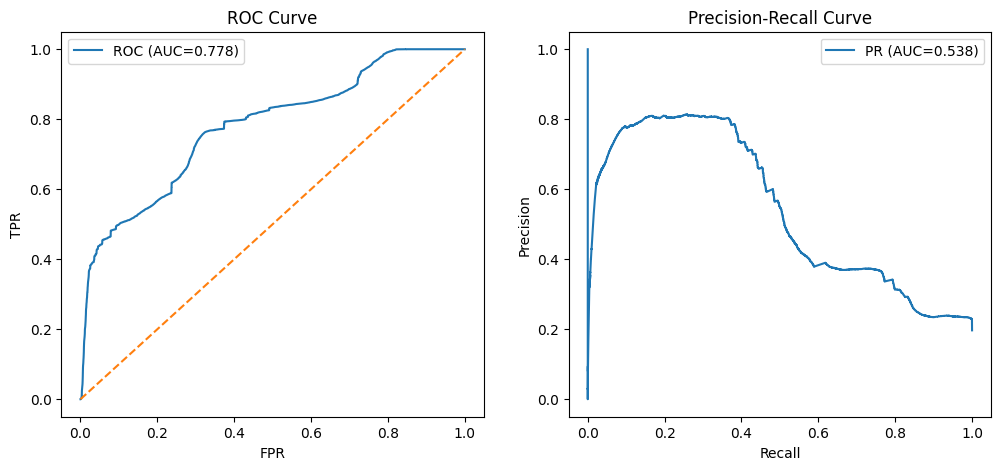

In [13]:
# ================================
# AE Evaluation as Anomaly Detector
#  - Threshold from benign training errors (e.g., 99th percentile)
# ================================
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import torch

# Build loaders
test_loader = DataLoader(LabeledDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# 1) Choose threshold from benign training distribution
with torch.no_grad():
    benign_loader = DataLoader(LabeledDataset(X_train_benign, np.zeros(len(X_train_benign))), batch_size=BATCH_SIZE, shuffle=False)
    benign_errs, _ = reconstruction_errors(global_model, benign_loader, DEVICE)

thresh = np.percentile(benign_errs, 99.0)   # tuneable: 95, 97.5, 99, etc.
print(f"Chosen threshold (99th percentile of benign recon error): {thresh:.6f}")

# 2) Score test set
test_errs, test_labels = reconstruction_errors(global_model, test_loader, DEVICE)

# Predictions: anomaly if recon error > threshold
y_pred = (test_errs > thresh).astype(int)

# Classification metrics
acc = accuracy_score(test_labels, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(test_labels, y_pred, average='binary', zero_division=0)

# Ranking metrics (use errors as anomaly scores)
roc_auc = roc_auc_score(test_labels, test_errs)
pr_auc  = average_precision_score(test_labels, test_errs)

print(f"ACC: {acc:.4f} | PREC: {prec:.4f} | REC: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

# 3) Curves
fpr, tpr, _ = roc_curve(test_labels, test_errs)
prec_c, rec_c, _ = precision_recall_curve(test_labels, test_errs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_c, prec_c, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()